In [1]:
import ot
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import scanpy as sc

/home/wuxinchao/.conda/envs/torch/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
prot_data_path = "/home/wuxinchao/data/st_cite_data/B01825A4_protein_filter.csv"
rna_data_path = "/home/wuxinchao/data/st_cite_data/B01825A4_rna_raw.csv"

In [3]:
prot_data = pd.read_csv(prot_data_path)
rna_data = pd.read_csv(rna_data_path)

In [4]:
# prot_data
# rna_data
gene_map = {
    "CD11c": "Itgax",
    "CD27" : "Cd27",
    "CD8a" : "Cd8a",
    "CD68" : "Cd68",
    "2" : "Thy1",
    "CD3" : "Cd3g",
    "CD44" : "Cd44",
    "CD5" : "Cd5",
    "CD4" : "Cd4",
    "CD29" : "Itgb1"
}
# gene_map["CD27"]

In [13]:
a = [.5, .5]
b = [.4, .6]
M = [[0, 1], [1, 0]]
ot.sinkhorn2(a, b, M, 1)

0.2805354607075431

In [14]:
ot.emd2(a, b, M)

0.09999999999999998

The Sinkhorn-Knopp algorithm is implemented in `ot.sinkhorn` and `ot.sinkhorn2` that return respectively the OT matrix and the value of the linear term.  
Using a regularization parameter that is not too small the default Sinkhorn solver should be enough. If you need to use a small regularization to get sharper OT matrices, you should use stablied solver that will avoid numerical errors. `ot.bregman.sinkhorn_epsilon_scaling` could be very slow and not even converge to a reasonable OT matrix in a finite time.  
The greedy version of the Sinkhorn `ot.bregman.greenkhorn` can also lead to a speedup and the screening version of the Sinkhorn `ot.bregman.screenkhorn` aim a providing a fast approximation of Sinkhorn problem.  
For use of GPU, use `ot.bregman.sinkhorn_log`

In [15]:
# prot_data.columns = prot_data.columns.str.split("_").str[-1]
prot_data.columns = prot_data.columns.str.split("_").str[-1]
# rename the columns of the prot_data based on the gene_map
prot_data.rename(columns=gene_map, inplace=True)

In [5]:
# using the data in prot_data replace the columns in rna_data
# rna_data[prot_data.columns] = prot_data
rna_data.index = rna_data["Unnamed: 0"]
rna_data.drop("Unnamed: 0", axis=1, inplace=True)
prot_data.index = prot_data["Unnamed: 0"]
prot_data.drop("Unnamed: 0", axis=1, inplace=True)

In [17]:
# (rna_data.align(prot_data, axis=0, join="inner"))
# rna_data
# prot_data.shape # (5974, 10)
fuzed_data = rna_data.join(prot_data, how="outer", lsuffix="_rna", rsuffix="_prot")

In [18]:
# convert the Nan to 0
fuzed_data = fuzed_data.fillna(0)
# for the columns that end with "_prot" and "_rna", keep the _prot feature and drop the _rna feature
fuzed_data = fuzed_data.loc[:,~fuzed_data.columns.str.endswith("_rna")]
# change the name of the columns, remove the "_prot" suffix
fuzed_data.columns = fuzed_data.columns.str.replace("_prot", "")

In [19]:
fuzed_data_path = "/home/wuxinchao/data/st_cite_data/B01825A4_fuzed_data.csv"
fuzed_data.to_csv(fuzed_data_path)

In [20]:
# fuzed_data.loc[:,fuzed_data.columns.str.endswith("_rna")]
# load the data into the scanpy, and the data is the fuzed_data
# And I want to transform the index of the fuzed_data to a new meta data in anndata
# The index of the fuzed_data is the location of the cell in the spatial slide, x_y is the location of the spot
# I want to transform the x_y to the meta data of the anndata object in the form of "x", "y"
fuzed_data_path = "/home/wuxinchao/data/st_cite_data/B01825A4_fuzed_data.csv"
adata = sc.read_csv(fuzed_data_path, first_column_names=True)

In [21]:
coordinates = fuzed_data.index.str.split("_", expand=True)
# convert the coordinates to the int type
coordinates = np.asarray(coordinates)
coordination = np.zeros((0, 2))
for coord in coordinates:
    x = int(coord[0])
    y = int(coord[1])
    coordination = np.vstack((coordination, [x, y]))

In [22]:
# download the data from the url and test the read coordinates function
# import urllib.request
# url_coord = "https://www.pnas.org/highwire/filestream/887973/field_highwire_adjunct_files/15/pnas.1912459116.sd15.xlsx"
# filename_coord = "./data/st_cite_data/pnas.1912459116.sd15.xlsx"
# urllib.request.urlretrieve(url_coord, filename_coord)

In [23]:
adata.obsm["spatial"] = coordination

In [24]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e6)
sc.pp.log1p(adata)
sc.pp.pca(adata, n_comps=15)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added="clusters", resolution=0.5)

In [25]:
adata

AnnData object with n_obs × n_vars = 9181 × 25818
    obs: 'n_counts', 'clusters'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

/home/wuxinchao/.conda/envs/torch/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


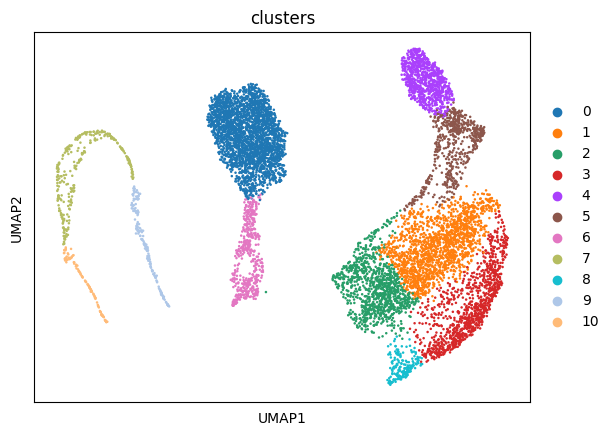

/home/wuxinchao/.conda/envs/torch/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


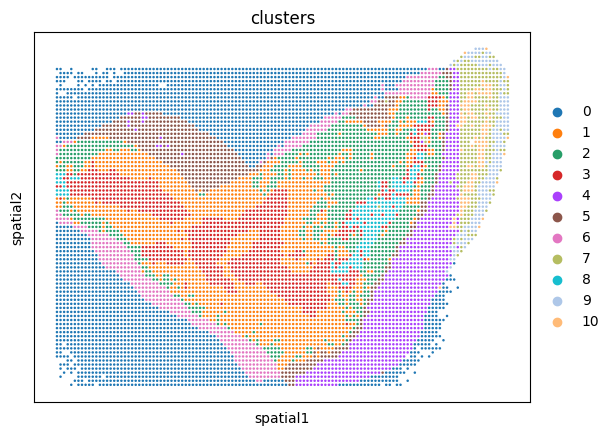

In [26]:
sc.pl.umap(adata, color="clusters")
sc.pl.embedding(adata, basis="spatial", color="clusters")

In [6]:
# rna_coords
rna_coords = rna_data.index.str.split("_", expand=True)
rna_coords = np.asarray(rna_coords)
rna_coordination = np.zeros((0, 2))
for coord in rna_coords:
    x = int(coord[0])
    y = int(coord[1])
    rna_coordination = np.vstack((rna_coordination, [x, y]))

# prot_coords
prot_coords = prot_data.index.str.split("_", expand=True)
prot_coords = np.asarray(prot_coords)
prot_coordination = np.zeros((0, 2))
for coord in prot_coords:
    x = int(coord[0])
    y = int(coord[1])
    prot_coordination = np.vstack((prot_coordination, [x, y]))

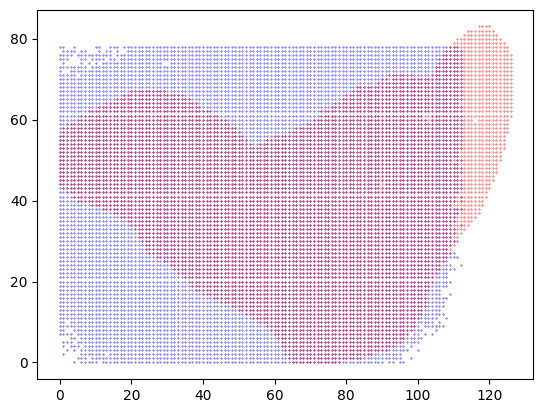

In [28]:
# rna_data.index.str.split("_", expand=True)
plt.scatter(rna_coordination[:, 0], rna_coordination[:, 1], c="b", marker="o", s = 0.1)
# plt.scatter(prot_coordination[:, 0], prot_coordination.max(axis=0)[1]-prot_coordination[:, 1], c="r", marker="o", s = 0.1)
plt.scatter(prot_coordination[:, 0], prot_coordination[:, 1], c="r", marker="o", s = 0.1)

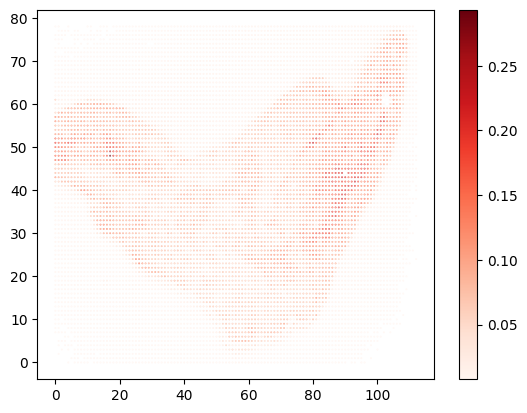

In [29]:
# plot the rna expression, colored with the rna mean expression
plt.scatter(rna_coordination[:,0], rna_coordination[:,1], marker="o", s = 0.1, c=rna_data.mean(axis=1), cmap="Reds")
plt.colorbar()

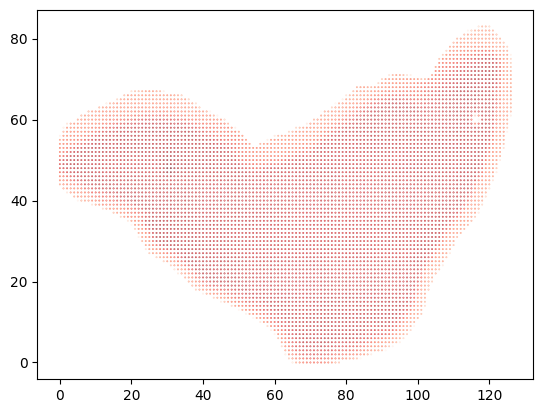

In [30]:
plt.scatter(prot_coordination[:,0], prot_coordination[:,1], marker="o", s = 0.1, c=np.log(prot_data.mean(axis=1)), cmap="Reds")

In [31]:
import matplotlib.pylab as pl
import torch
import matplotlib.animation as animation

XX, YY = np.meshgrid(np.arange(prot_coordination.shape[0]), np.arange(prot_coordination.shape[0]))

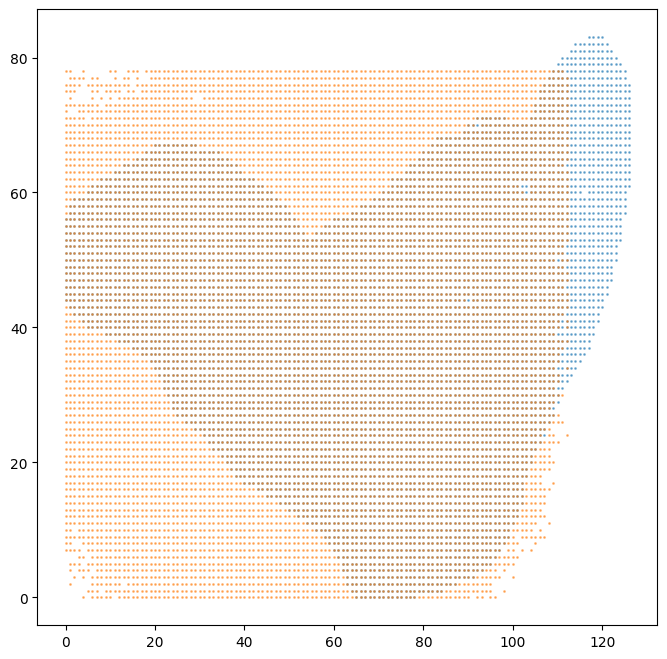

In [32]:
# prot_data.mean(axis=1)
# x1 = np.stack((XX[I1 == 0], YY[I1 == 0]), axis=1) * 1.0

pl.figure(1, (8, 8))
pl.scatter(prot_coordination[:, 0], prot_coordination[:, 1], alpha=0.5, s=1)
pl.scatter(rna_coordination[:, 0], rna_coordination[:, 1], alpha=0.5, s=1)

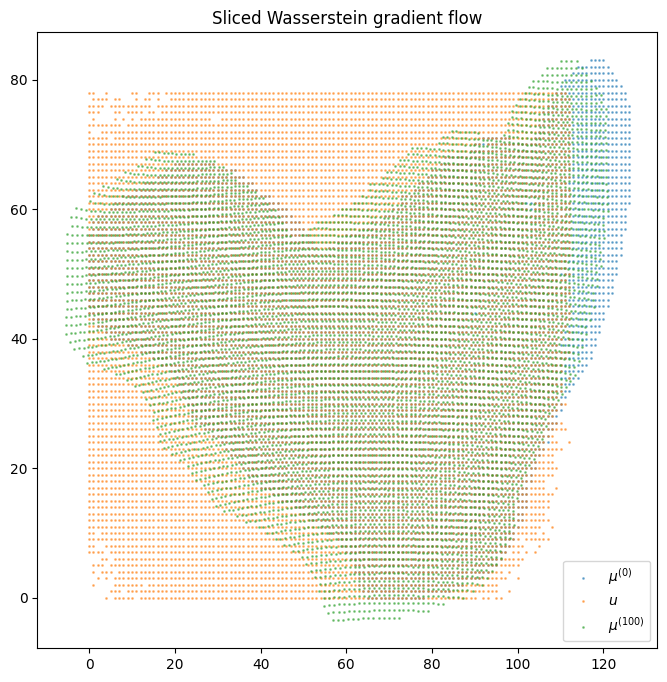

In [33]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# use pyTorch for our data
x1 = torch.tensor(prot_coordination, dtype=torch.float32).to(device).requires_grad_(True)
x2 = torch.tensor(rna_coordination, dtype=torch.float32).to(device)

lr = 1e3
nb_iter_max = 100
x_all = np.zeros((nb_iter_max, x1.shape[0], 2))
loss_iter = []

# generator for random permutations
gen = torch.Generator()
gen.manual_seed(42)

for i in range(nb_iter_max):
    loss = ot.sliced_wasserstein_distance(x1, x2, n_projections=50, seed=gen)
    loss_iter.append(loss.clone().detach().cpu().numpy())
    loss.backward()

    # performs a step of projected gradient descent
    with torch.no_grad():
        grad = x1.grad
        x1 -= grad * lr / (1 + i / 5e1) # step
        x1.grad.zero_()
        x_all[i, :, :] = x1.clone().detach().cpu().numpy()

xb = x1.clone().detach().cpu().numpy()

pl.figure(2, (8, 8))
pl.scatter(prot_coordination[:, 0], prot_coordination[:,1], alpha=0.5, s=1, label="$\mu^{(0)}$")
pl.scatter(x2[:, 0], x2[:, 1], alpha=0.5, s=1, label="$u$")
pl.scatter(xb[:, 0], xb[:, 1], alpha=0.5, s=1, label="$\mu^{(100)}$")
pl.title("Sliced Wasserstein gradient flow")
pl.legend()
ax = pl.axis()

In [35]:
# ot.bregman.sinkhorn()

In [36]:
rna_data.mean(axis=1) * 1000

Unnamed: 0
37_3       9.218375
23_65     13.169107
78_72     14.408552
94_32     43.070726
42_4       9.760632
            ...    
84_9      14.176156
99_5       8.404989
18_68      9.644434
112_40     8.908513
22_2       9.102177
Length: 8605, dtype: float64

In [7]:
rna_df = pd.DataFrame(rna_data.mean(axis=1) * 1000, index=rna_data.index)
rna_df["X"] = rna_coordination[:, 0]
rna_df["Y"] = rna_coordination[:, 1]

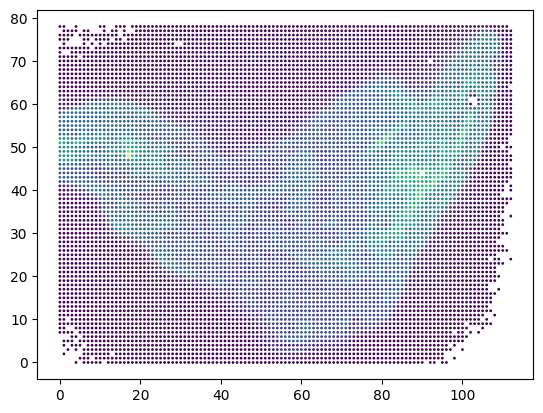

In [8]:
plt.scatter(rna_df["X"], rna_df["Y"], c=rna_df[0], marker="o", s = 1)

In [9]:
prot_df = pd.DataFrame(prot_data.mean(axis=1), index=prot_data.index)
prot_df["X"] = prot_coordination[:, 0]
prot_df["Y"] = prot_coordination[:, 1]

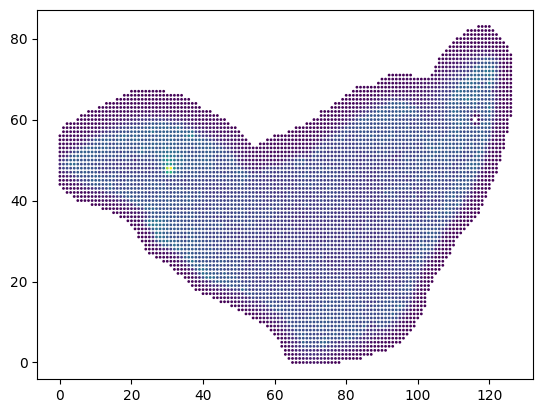

In [10]:
plt.scatter(prot_df["X"], prot_df["Y"], c=prot_df[0], marker="o", s = 1)

In [11]:
# implement the OT mapping of the rna and protein expression data
# use the rna data as the source and the protein data as the target

# the fisrt step is to fill the missing values in the protein data and rna data with zeros
# define the meshgrid of the matrix coordination of protein data
rna_mtx, prot_mtx = np.meshgrid(np.arange(prot_df["X"].max()+1), np.arange(prot_df["Y"].max()+1))
rna_mtx = np.zeros_like(rna_mtx).T
prot_mtx = np.zeros_like(prot_mtx).T

# fill the grid with the protein data value
for i in range(prot_df.shape[0]):
    spot = prot_df.iloc[i]
    x = int(spot["X"])
    y = int(spot["Y"])
    prot_mtx[x, y] = spot[0]

# fill the grid with the rna data value
for i in range(rna_df.shape[0]):
    spot = rna_df.iloc[i]
    x = int(spot["X"])
    y = int(spot["Y"])
    rna_mtx[x, y] = spot[0]

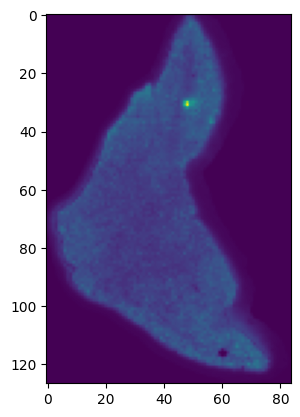

In [12]:
plt.imshow(prot_mtx)

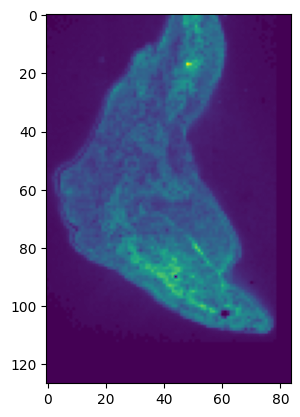

In [13]:
plt.imshow(rna_mtx)

In [14]:
# ot.dist(prot_mtx, rna_mtx)
# prot_mtx.flatten().shape, rna_mtx.flatten().shape
# define the cost matrix of the OT mapping
C = ot.dist(prot_mtx.flatten().reshape(-1, 1), rna_mtx.flatten().reshape(-1, 1))
# compute the OT mapping of the protein data to the rna data
# G0 = ot.emd(prot_mtx.flatten(), rna_mtx.flatten(), C)

In [17]:
# cost matrix
M = ot.dist(prot_mtx.flatten().reshape(-1, 1), rna_mtx.flatten().reshape(-1, 1), metric='euclidean')
# 2-wasserstein distance
M2 = pow(M, 2)

In [18]:
alpha = ot.unif(len(prot_mtx.flatten()))
beta = ot.unif(len(rna_mtx.flatten()))

In [20]:
# exact solution
P = ot.emd(alpha, beta, M, numItermax=1e5)
# Sinkhorn approximation solution
entropy_reg = 0.5 # regularization term
P_sinkhorn = ot.sinkhorn(alpha, beta, M, entropy_reg, numItermax=1000, method='sinkhorn')

RESULT MIGHT BE INACURATE
Max number of iteration reached, currently 100000. Sometimes iterations go on in cycle even though the solution has been reached, to check if it's the case here have a look at the minimal reduced cost. If it is very close to machine precision, you might actually have the correct solution, if not try setting the maximum number of iterations a bit higher
/home/wuxinchao/.conda/envs/torch/lib/python3.10/site-packages/ot/bregman.py:485: RuntimeWarning: divide by zero encountered in divide
  u = 1. / nx.dot(Kp, v)
/home/wuxinchao/.conda/envs/torch/lib/python3.10/site-packages/ot/bregman.py:485: RuntimeWarning: overflow encountered in divide
  u = 1. / nx.dot(Kp, v)
/home/wuxinchao/.conda/envs/torch/lib/python3.10/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 0
  warnings.warn('Warning: numerical errors at iteration %d' % ii)


In [25]:
p = 1
# calculate the p-wasserstein distance
# pW = M * P
# direct calculate the p-wasserstein distance
# exact solution
pW = ot.emd2(alpha, beta, M, P)
# sinkhorn
pW_sinkhorn = ot.sinkhorn2(alpha, beta, M, reg=entropy_reg, numItermax=1000, method='sinkhorn')

RESULT MIGHT BE INACURATE
Max number of iteration reached, currently 100000. Sometimes iterations go on in cycle even though the solution has been reached, to check if it's the case here have a look at the minimal reduced cost. If it is very close to machine precision, you might actually have the correct solution, if not try setting the maximum number of iterations a bit higher
/home/wuxinchao/.conda/envs/torch/lib/python3.10/site-packages/ot/lp/__init__.py:547: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)
/home/wuxinchao/.conda/envs/torch/lib/python3.10/site-packages/ot/bregman.py:485: RuntimeWarning: divide by zero encountered in divide
  u = 1. / nx.dot(Kp, v)
/home/wuxinchao/.conda/envs/torch/lib/python3.10/site-packages/ot/bregman.py:485: RuntimeWarning: overflow encountered in divide
  u = 1. / nx.dot(Kp, v)
/home/wuxinchao/.conda/envs/torch/lib/python3.10/site-packages/ot/bregman.py:492: UserWarning: Warning: numerica

In [27]:
# (pW - pW_sinkhorn).sum()
pW
# pW_sinkhorn

209.4342866594374

In [28]:
p=2
pW = pow(ot.emd2(alpha, beta, M2), 1/p)
pW_sinkhorn = pow(ot.sinkhorn2(alpha, beta, M2, reg=entropy_reg, numItermax=1000, method='sinkhorn'), 1/p)

RESULT MIGHT BE INACURATE
Max number of iteration reached, currently 100000. Sometimes iterations go on in cycle even though the solution has been reached, to check if it's the case here have a look at the minimal reduced cost. If it is very close to machine precision, you might actually have the correct solution, if not try setting the maximum number of iterations a bit higher


In [30]:
# get the fuzed data of the protein data and rna data
# the fuzed data is the weighted average of the protein data and rna data
# the weight is the OT mapping matrix

fuzed_mtx = ot.unif(len(prot_mtx.flatten()))
fuzed_mtx = fuzed_mtx.reshape(prot_mtx.shape)


0.01311393370914127

In [ ]:
# def S_loss_compute(alpha, beta, M):
#     """
#     compute the S_loss
#     """
#     S_loss = ot.emd2(alpha, beta, M) - (ot.emd2(alpha, alpha) + ot.emd2(beta, beta)) / 2
#     return S_loss

# def batch_sinkhornj_imputation(X, omega, alpha, eta, episilon, n, m):
#     for j in range(X.shape[1]):
#         for i in range(omega.shape[0]):
#             print(omega)

# def OTimputer(eps = 0.01, max_iter=10, niter=15, batch_size=128, n_pairs=10):
#     X = X.clone()
#     n, d = X.shape
#     omega = torch.zeros(n, n)

from ot import da

# compute optimal transport map
G = da.cost_matrix(rna_mtx, prot_mtx)
a, b = np.ones((rna_mtx.shape[0],)) / rna_mtx.shape[0], np.ones((prot_mtx.shape[0],)) / prot_mtx.shape[0]
lambd = 1e-3
p = da.sinkhorn(a, b, G, lambd, numItermax=1000)

# fuse data mtx
fuzed_mtx = (P @ rna_mtx.reshape(-1)).reshape(prot_mtx.shape)

# Display the results
plt.figure(1, figsize=(10, 10))
plt.subplot(221)
plt.imshow(rna_mtx, interpolation='nearest')
plt.title('Source data')
plt.subplot(222)
plt.imshow(prot_mtx, interpolation='nearest')
plt.title('Target data')
plt.subplot(223)
plt.imshow(fuzed_mtx, interpolation='nearest')
plt.title('Fuzed data')
plt.subplot(224)
plt.imshow(P, interpolation='nearest')
plt.title('OT matrix')
plt.tight_layout()
plt.show()

In [ ]:
# not used
# exp(A) calculate
A = np.array([[1, 2], [3, 4]])
eA = np.zeros_like(A)
for i in range(100):
    temp = np.power(A, i) / np.math.factorial(i)
    if temp.sum() < 1e-6:
        break
    eA = eA + temp
    print(eA)
print(f"The true value is {np.exp(A)}")

np.diag(np.diag(A))

[[1. 1.]
 [1. 1.]]
[[2. 3.]
 [4. 5.]]
[[ 2.5  5. ]
 [ 8.5 13. ]]
[[ 2.66666667  6.33333333]
 [13.         23.66666667]]
[[ 2.70833333  7.        ]
 [16.375      34.33333333]]
[[ 2.71666667  7.26666667]
 [18.4        42.86666667]]
[[ 2.71805556  7.35555556]
 [19.4125     48.55555556]]
[[ 2.71825397  7.38095238]
 [19.84642857 51.80634921]]
[[ 2.71827877  7.38730159]
 [20.00915179 53.43174603]]
[[ 2.71828153  7.38871252]
 [20.06339286 54.15414462]]
[[ 2.7182818   7.38899471]
 [20.07966518 54.44310406]]
[[ 2.71828183  7.38904602]
 [20.08410308 54.54818021]]
[[ 2.71828183  7.38905457]
 [20.08521256 54.5832056 ]]
[[ 2.71828183  7.38905588]
 [20.08546859 54.59398264]]
[[ 2.71828183  7.38905607]
 [20.08552346 54.5970618 ]]
[[ 2.71828183  7.3890561 ]
 [20.08553443 54.59788291]]
[[ 2.71828183  7.3890561 ]
 [20.08553649 54.59808818]]
[[ 2.71828183  7.3890561 ]
 [20.08553685 54.59813648]]
[[ 2.71828183  7.3890561 ]
 [20.08553691 54.59814722]]
[[ 2.71828183  7.3890561 ]
 [20.08553692 54.59814948]]
